In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /content/sample_data/horse-or-human.zip

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /content/sample_data/validation-horse-or-human.zip
  
import os
import zipfile

--2020-06-11 11:12:53--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 2a00:1450:4013:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/content/sample_data/horse-or-human.zip’

/content/sample_dat 100%[===================>] 142.65M  88.9MB/s    in 1.6s    

2020-06-11 11:12:55 (88.9 MB/s) - ‘/content/sample_data/horse-or-human.zip’ saved [149574867/149574867]

--2020-06-11 11:12:56--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 2a00:1450:4013:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Le

In [0]:
local_zip = '/content/sample_data/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/sample_data/horse-or-human')
local_zip = '/content/sample_data/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/sample_data/validation-horse-or-human')
zip_ref.close()

In [0]:
# Directory with our training horse pictures
train_horse_dir = os.path.join('/content/sample_data/horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('/content/sample_data/horse-or-human/humans')

# Directory with our training horse pictures
validation_horse_dir = os.path.join('/content/sample_data/validation-horse-or-human/horses')

# Directory with our training human pictures
validation_human_dir = os.path.join('/content/sample_data/validation-horse-or-human/humans')

In [4]:
print(len(os.listdir('/content/sample_data/horse-or-human/horses/')))
print(len(os.listdir('/content/sample_data/horse-or-human/humans/')))
print(len(os.listdir('/content/sample_data/validation-horse-or-human/horses/')))
print(len(os.listdir('/content/sample_data/validation-horse-or-human/humans/')))

500
527
128
128


In [13]:
from tensorflow.keras import layers
from tensorflow.keras import Model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

#local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = 'imagenet')

#pre_trained_model.load_weights(local_weights_file)
#we are freezing all layers of the model
for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [14]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
TRAINING_DIR = '/content/sample_data/horse-or-human'
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# TRAIN GENERATOR.
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=64,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = '/content/sample_data/validation-horse-or-human'
validation_datagen = ImageDataGenerator(rescale=1/255)

# VALIDATION GENERATOR.
validation_generator =  validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                    batch_size=64,
                                                    class_mode='binary',
                                                    target_size=(150, 150)) 

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [16]:
history = model.fit(train_generator,
                              epochs=20,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/20
17/17 [==============================] - 13s 738ms/step - loss: 1.9887 - accuracy: 0.8880 - val_loss: 0.0827 - val_accuracy: 0.9805
Epoch 2/20
17/17 [==============================] - 12s 686ms/step - loss: 0.1204 - accuracy: 0.9805 - val_loss: 0.0448 - val_accuracy: 0.9922
Epoch 3/20
17/17 [==============================] - 12s 686ms/step - loss: 0.1294 - accuracy: 0.9825 - val_loss: 0.5738 - val_accuracy: 0.9531
Epoch 4/20
17/17 [==============================] - 12s 686ms/step - loss: 0.1223 - accuracy: 0.9805 - val_loss: 1.3129 - val_accuracy: 0.8945
Epoch 5/20
17/17 [==============================] - 12s 689ms/step - loss: 0.0654 - accuracy: 0.9922 - val_loss: 2.7070e-04 - val_accuracy: 1.0000
Epoch 6/20
17/17 [==============================] - 12s 685ms/step - loss: 0.0980 - accuracy: 0.9854 - val_loss: 0.1784 - val_accuracy: 0.9766
Epoch 7/20
17/17 [==============================] - 12s 688ms/step - loss: 0.0283 - accuracy: 0.9971 - val_loss: 0.1363 - val_accuracy: 0.

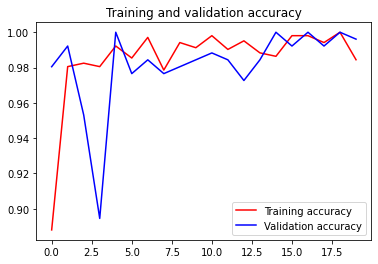

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

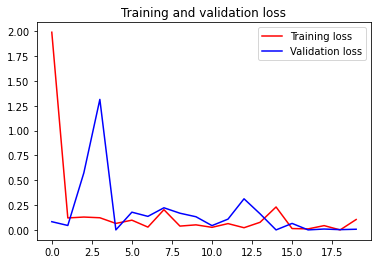

<Figure size 432x288 with 0 Axes>

In [18]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()